# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [51]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

# import check_test
from plot_utils import plot_values

In [66]:
import unittest 
from IPython.display import Markdown, display
import numpy as np



def printmd(string):
    display(Markdown(string))

V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

pol_opt = np.hstack((np.ones(11), 2, 0))

V_true = np.zeros((4,12))
for i in range(3):
    V_true[0:13][i] = -np.arange(3, 15)[::-1] - i
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17

def get_long_path(V):
    return np.array(np.hstack((V[0:13][0], V[1][0], V[1][11], V[2][0], V[2][11], V[3][0], V[3][11])))

def get_optimal_path(policy):
    return np.array(np.hstack((policy[2][:], policy[3][0])))

class Tests(unittest.TestCase):

    def td_prediction_check(self, V):
        to_check = get_long_path(V)
        soln = get_long_path(V_true)
        np.testing.assert_array_almost_equal(soln, to_check)

    def td_control_check(self, policy):
        to_check = get_optimal_path(policy)
        np.testing.assert_equal(pol_opt, to_check)
        

def run_check(check_name, func):
    try:
        getattr(check, check_name)(func)
    except check.failureException as e:
        printmd('**<span style="color: red;">PLEASE TRY AGAIN</span>**')
        return
    printmd('**<span style="color: green;">PASSED</span>**')



if __name__ == "__main__":
    check = Tests()

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [52]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [53]:
#actions just go up down left right
print(env.action_space)

#the map
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

/home/rm/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


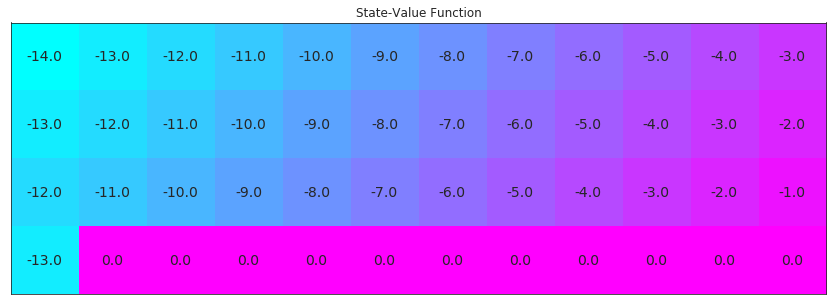

In [54]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [123]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    return new_value


# def epsilon_greedy(Q, state, epsilon, nA = 4):
#     seed = np.random.random(1)[0]

#     if seed < epsilon:
#         #random
# #         print("random")
#         action = np.random.choice(np.arange(nA), p=np.ones(nA)/nA)
#     else:
#         #greedy
# #         print("greedy")
#         action = np.argmax(Q[state])
        
#     return int(action)
              
def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))

    
def sarsa(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):

    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes
    epsilon = eps_start
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        state = env.reset()
        
        #set epsilon decay, v important 
        epsilon = 1.0 / i_episode     

        #choose action from epsilon greedy, start is 36, terminal 47
        action = epsilon_greedy(Q, state, env.nA, epsilon)

        while True:
            next_state, reward, done, info = env.step(action)

            next_action = epsilon_greedy(Q, next_state, env.nA, epsilon)
            
            #update Q
            Qsa_next = Q[next_state][next_action] if not done else 0
            Q[state][action] = (1-alpha)*(Q[state][action]) + \
                        alpha*(reward + (gamma * Qsa_next))
            
            state = next_state
            action = next_action

            if done:
                break
            
        
    return Q



Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  1  2  2  1  0  0  1  1  0  2  2]
 [ 1  1  1  1  1  1  2  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


/home/rm/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


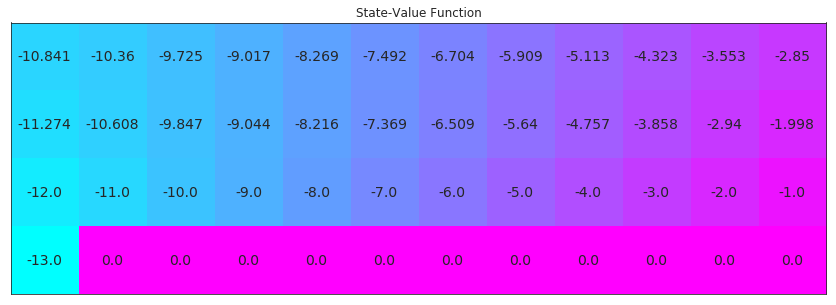

In [126]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [61]:
def q_learning(env, num_episodes, alpha, gamma=1.0,  eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    epsilon = eps_start
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        state = env.reset()
        
        #set epsilon decay

        epsilon = max(epsilon*eps_decay, eps_min)
        #choose action from epsilon greedy, start is 36, terminal 47
        action = epsilon_greedy(Q, state, epsilon)

        while True:
            #print(action)
            next_state, reward, done, info = env.step(action)
            next_action = epsilon_greedy(Q, state, epsilon)

            
            #update Q
            Q[state][action] = (1-alpha)*Q[state][action] + \
                        alpha*(reward+gamma*np.amax(Q[next_state]))
            
            state = next_state
            action = next_action
            
            if done:
                break
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


/home/rm/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


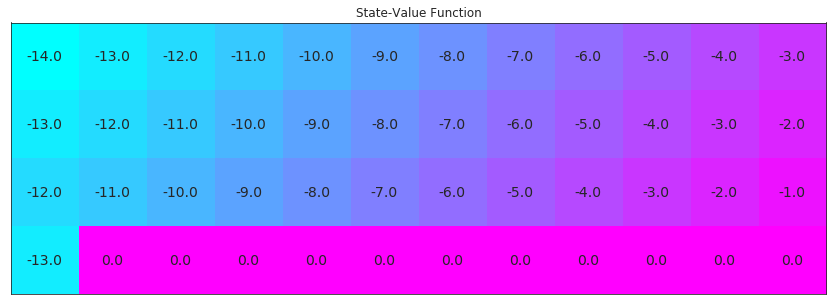

In [69]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [138]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    epsilon = eps_start
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        state = env.reset()
        
        #set epsilon decay

        #epsilon = max(epsilon*eps_decay, eps_min)
        #epsilon = 1.0/i_episode
        
        epsilon = 0.005
        
        #choose action from epsilon greedy, start is 36, terminal 47
        action = epsilon_greedy(Q, state, env.nA, epsilon)

        while True:
            #print(action)
            next_state, reward, done, info = env.step(action)
            next_action = epsilon_greedy(Q, next_state, env.nA, epsilon)
            
            #update Q
            Qsa_next = (1-epsilon)*np.amax(Q[next_state]) + epsilon*np.mean(Q[next_state]) if not done else 0
            
            Q[state][action] = (1-alpha)*Q[state][action] + \
                        alpha*(reward+gamma*Qsa_next)
            
            state = next_state
            action = next_action
            
            if done:
                break
                
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 1000/1000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  1  0  1  1  0  1  1  3  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


/home/rm/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


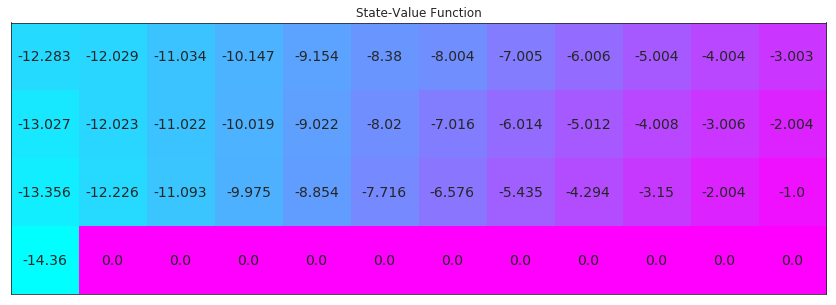

In [139]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 1000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])